In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
from scipy.signal import cwt
from scipy import signal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
import random
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
mit_test = pd.read_csv("drive/MyDrive/Datascientest/Data/mitbih_test.csv", header = None)
mit_train = pd.read_csv("drive/MyDrive/Datascientest/Data/mitbih_train.csv", header = None)



In [ ]:
X_train_mit = mit_train.iloc[:,:-1]
y_train_mit = mit_train.iloc[:,-1]
X_test_mit = mit_test.iloc[:,:-1]
y_test_mit = mit_test.iloc[:,-1]


In [ ]:
ru = RandomUnderSampler(replacement = True) 
X_train_mit, y_train_mit = ru.fit_resample(X_train_mit, y_train_mit)

In [ ]:
from datetime import datetime
now = datetime.now()
X_train = []
y_train = []
for i in range(X_train_mit.shape[0]):
    img = cwt(data = X_train_mit.iloc[i,:], wavelet = signal.ricker, widths = np.arange(1, 30))
    X_train.append(np.repeat(img[..., np.newaxis], 3, -1))
    y_train.append(y_train_mit.iloc[i])

X_train = np.array(X_train)
print(datetime.now() - now)

0:00:17.585679


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


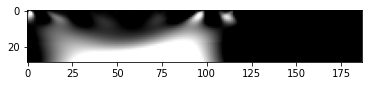

In [ ]:
plt.imshow(X_train[156])

In [ ]:
plt.imshow(X_train[156])

In [ ]:
model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet', input_tensor=Input(shape=(29, 187, 3)),
    pooling=None, classes=1000
)

In [ ]:
model.summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29, 187, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 35, 193, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 15, 94, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 15, 94, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
for layer in model.layers :
    layer.trainable = False


In [ ]:
output = Dense(units = 5, activation="softmax", name="final" )(model.layers[-2].output)
model_2 = Model(inputs = model.input, outputs = output)
model_2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


In [ ]:
model_2.fit(X_train, to_categorical(y_train), epochs = 30, batch_size = 32, validation_split = 0.2)

Epoch 1/30
81/81 [==============================] - 32s 149ms/step - loss: 0.9327 - accuracy: 0.6560 - val_loss: 7.7259 - val_accuracy: 0.0000e+00
Epoch 2/30
81/81 [==============================] - 7s 92ms/step - loss: 0.6471 - accuracy: 0.7551 - val_loss: 7.8931 - val_accuracy: 0.0000e+00
Epoch 3/30
81/81 [==============================] - 7s 89ms/step - loss: 0.5809 - accuracy: 0.7867 - val_loss: 8.5291 - val_accuracy: 0.0000e+00
Epoch 4/30
81/81 [==============================] - 8s 103ms/step - loss: 0.5335 - accuracy: 0.8077 - val_loss: 9.1446 - val_accuracy: 0.0000e+00
Epoch 5/30
81/81 [==============================] - 8s 104ms/step - loss: 0.4980 - accuracy: 0.8210 - val_loss: 9.3264 - val_accuracy: 0.0000e+00
Epoch 6/30
81/81 [==============================] - 7s 90ms/step - loss: 0.4747 - accuracy: 0.8307 - val_loss: 9.3316 - val_accuracy: 0.0000e+00
Epoch 7/30
81/81 [==============================] - 7s 89ms/step - loss: 0.4572 - accuracy: 0.8420 - val_loss: 9.8541 - val_ac

In [ ]:
now = datetime.now()
X_test = []
y_test = []
for i in range(10000):
    rand = random.randint(0,mit_test.shape[0])
    img = cwt(data = X_test_mit.iloc[rand,:], wavelet = signal.ricker, widths = np.arange(1, 30))
    X_test.append(np.repeat(img[..., np.newaxis], 3, -1))
    y_test.append(y_test_mit.iloc[rand])

X_test = np.array(X_test)
print(datetime.now() - now)

0:00:36.401651


In [ ]:
prediction = model_2.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

display(pd.crosstab(np.array(y_test), prediction.argmax(1)))

print(classification_report(np.array(y_test), prediction.argmax(1)))

col_0,0,1,2,3
row_0,,,,
0.0,6438,875,498,443
1.0,30,193,10,6
2.0,10,31,629,34
3.0,3,2,4,69
4.0,16,20,664,25


              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      8254
         1.0       0.17      0.81      0.28       239
         2.0       0.35      0.89      0.50       704
         3.0       0.12      0.88      0.21        78
         4.0       0.00      0.00      0.00       725

    accuracy                           0.73     10000
   macro avg       0.33      0.67      0.37     10000
weighted avg       0.85      0.73      0.76     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
